In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

### Flowchart step 0 - Raw Nightingale dataset 

In [2]:
outcomes_df = pd.read_csv("outcomes.csv")

In [3]:
print("Initial cohort: Number of biopsies: ", outcomes_df.biopsy_id.nunique())
print("Initial cohort: Number of patients: ", outcomes_df.patient_ngsci_id.nunique())  

Initial cohort: Number of biopsies:  3255
Initial cohort: Number of patients:  2567


In [4]:
outcomes_df.stage.isna().sum()

np.int64(534)

In [13]:
# check also biopsy-slides.csv for initial WSI count

In [7]:
biopsy_slides_df = pd.read_csv("biopsy-slides.csv") 

In [8]:
biopsy_slides_df.shape

(52262, 4)

In [10]:
biopsy_slides_df.slide_id.nunique()

52262

In [11]:
biopsy_slides_df.biopsy_id.nunique()

3256

In [12]:
biopsy_slides_df.patient_ngsci_id.nunique()

2568

In [14]:
# almost identical to biopsy and patient counts from outcomes.csv, use the latter

### Flowchart step 1 - Nightingale dataset after removing patients with completely missing cancer stage

In [ ]:
merged_df = pd.read_csv('merged_metadata_v2.1.csv')
merged_df.head(2)

In [6]:
print("Number of biopsies excluded: ", outcomes_df.biopsy_id.nunique() - merged_df.biopsy_id.nunique())
print("Number of patients excluded: ", outcomes_df.patient_ngsci_id.nunique() - merged_df.patient_ngsci_id.nunique())  

Number of biopsies excluded:  534
Number of patients excluded:  483


In [7]:
print("Number of biopsies: ", merged_df.biopsy_id.nunique())
print("Number of patients: ", merged_df.patient_ngsci_id.nunique())  

Number of biopsies:  2721
Number of patients:  2084


### Perform filtering for stages I-IV and no neoadjuvant treatments - this keeps cases with stages I-IV where there was no neoadjuvant treatment (response_neoadjuv_therapy = 0) or the response_neoadjuv_therapy column is NaN (unknown)

In [8]:
filt_stages_treatment = (merged_df.stage > 0) &\
( (merged_df.response_neoadjuv_therapy == 0 ) | ( np.isnan(merged_df.response_neoadjuv_therapy)) ) &\
 merged_df.immuno_therapy_cd.isin([0, 82, 85, 86, 87]) 
filt_stages_treatment.sum()

np.int64(1930)

In [9]:
print("Number of biopsies excluded: ", merged_df.biopsy_id.nunique() - merged_df[filt_stages_treatment].biopsy_id.nunique())
print("Number of patients excluded: ", merged_df.patient_ngsci_id.nunique() - merged_df[filt_stages_treatment].patient_ngsci_id.nunique())  

Number of biopsies excluded:  791
Number of patients excluded:  638


In [10]:
print("Number of biopsies: ", merged_df[filt_stages_treatment].biopsy_id.nunique())
print("Number of patients: ", merged_df[filt_stages_treatment].patient_ngsci_id.nunique())  

Number of biopsies:  1930
Number of patients:  1446


In [11]:
merged_df = merged_df[filt_stages_treatment]
merged_df.reset_index(inplace=True, drop=True)

### Select NaN response_neoadjuv_therapy using treatment dates that are prior to biopsy date

In [12]:
merged_df.response_neoadjuv_therapy.isna()

0        True
1       False
2       False
3       False
4        True
        ...  
1925    False
1926     True
1927     True
1928    False
1929    False
Name: response_neoadjuv_therapy, Length: 1930, dtype: bool

In [13]:
merged_neo_nan_df = merged_df[ merged_df.response_neoadjuv_therapy.isna() ]
merged_neo_nan_df.shape

(1278, 44)

In [14]:
biopsy_date = merged_neo_nan_df.biopsy_dt.values.astype(str)
biopsy_date[ biopsy_date == 'nan' ] = '0100-01-01' # set to this to mark NaNs with 0
biopsy_date = np.array( [ datetime.timestamp( datetime.strptime(b, "%Y-%m-%d") ) for b in biopsy_date ] ) # shift back
biopsy_date

array([4.5748800e+09, 4.6680192e+09, 4.6601568e+09, ..., 4.6323360e+09,
       4.5886176e+09, 4.5896544e+09])

In [15]:
radiation_start_dt_date = merged_neo_nan_df.radiation_start_dt.values.astype(str)
radiation_start_dt_date[ radiation_start_dt_date == 'nan' ] = '0100-01-01' # set to this to mark NaNs with 0
radiation_start_dt_date = np.array( [ datetime.timestamp( datetime.strptime(b, "%Y-%m-%d") ) for b in radiation_start_dt_date ] ) # shift back
radiation_start_dt_date

array([ 4.58930880e+09,  4.67467200e+09,  4.66404480e+09, ...,
        4.65333120e+09,  4.60131840e+09, -5.90114592e+10])

(array([517.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 761.]),
 array([-5.90114592e+10, -5.26360205e+10, -4.62605818e+10, -3.98851430e+10,
        -3.35097043e+10, -2.71342656e+10, -2.07588269e+10, -1.43833882e+10,
        -8.00794944e+09, -1.63251072e+09,  4.74292800e+09]),
 <BarContainer object of 10 artists>)

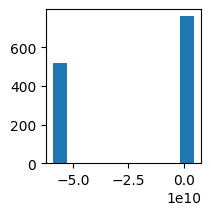

In [16]:
plt.figure(figsize=(2,2))
plt.hist(radiation_start_dt_date)

In [17]:
rx_chemo_dt_date = merged_neo_nan_df.rx_chemo_dt.values.astype(str)
rx_chemo_dt_date[ rx_chemo_dt_date == 'nan' ] = '0100-01-01' # set to this to mark NaNs with 0
rx_chemo_dt_date = np.array( [ datetime.timestamp( datetime.strptime(b, "%Y-%m-%d") ) for b in rx_chemo_dt_date ] ) # shift back
rx_chemo_dt_date

array([ 4.57729920e+09, -5.90114592e+10, -5.90114592e+10, ...,
        4.63302720e+09,  4.59138240e+09, -5.90114592e+10])

(array([940.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 338.]),
 array([-5.90114592e+10, -5.26375930e+10, -4.62637267e+10, -3.98898605e+10,
        -3.35159942e+10, -2.71421280e+10, -2.07682618e+10, -1.43943955e+10,
        -8.02052928e+09, -1.64666304e+09,  4.72720320e+09]),
 <BarContainer object of 10 artists>)

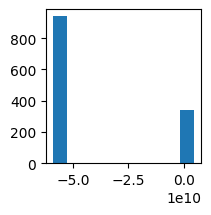

In [18]:
plt.figure(figsize=(2,2))
plt.hist(rx_chemo_dt_date)

In [19]:
rx_hormone_dt_date = merged_neo_nan_df.rx_hormone_dt.values.astype(str)
rx_hormone_dt_date[ rx_hormone_dt_date == 'nan' ] = '0100-01-01' # set to this to mark NaNs with 0
rx_hormone_dt_date = np.array( [ datetime.timestamp( datetime.strptime(b, "%Y-%m-%d") ) for b in rx_hormone_dt_date ] ) # shift back
rx_hormone_dt_date

array([-5.90114592e+10,  4.67968320e+09,  4.66862400e+09, ...,
        4.65886080e+09, -5.90114592e+10,  4.59250560e+09])

(array([ 261.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1017.]),
 array([-5.90114592e+10, -5.26357872e+10, -4.62601152e+10, -3.98844432e+10,
        -3.35087712e+10, -2.71330992e+10, -2.07574272e+10, -1.43817552e+10,
        -8.00608320e+09, -1.63041120e+09,  4.74526080e+09]),
 <BarContainer object of 10 artists>)

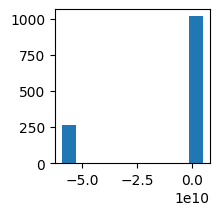

In [20]:
plt.figure(figsize=(2,2))
plt.hist(rx_hormone_dt_date)

#### all entries with dates 

In [21]:
filt_all_treament_date = (radiation_start_dt_date > 0) & ( rx_chemo_dt_date > 0) & (rx_hormone_dt_date > 0) 
filt_all_treament_date[:5], filt_all_treament_date.sum()

(array([False, False, False, False, False]), np.int64(165))

In [22]:
filt_all_treatment_date_after_biopsy_date = (biopsy_date[filt_all_treament_date] < radiation_start_dt_date[filt_all_treament_date] )&\
        (biopsy_date[filt_all_treament_date] < rx_chemo_dt_date[filt_all_treament_date] )&\
        (biopsy_date[filt_all_treament_date] < rx_hormone_dt_date[filt_all_treament_date] )
filt_all_treatment_date_after_biopsy_date.sum()

np.int64(124)

So there are 124 biopsies where the response_neoadjuv_therapy is NaN (unknown) but all treatment dates are available and based on treatment dates and biopsy date, we can infer that there was no neoadjuvant treatment for those additional 124 biopsies

#### all entries without date in any of treatments

In [23]:
filt_any_treatment_date_nan = (radiation_start_dt_date < 0) | ( rx_chemo_dt_date < 0) | (rx_hormone_dt_date < 0) 
filt_any_treatment_date_nan[:5], filt_any_treatment_date_nan.sum()

(array([ True,  True,  True,  True,  True]), np.int64(1113))

In [24]:
filt_any_treatment_nan_with_code = ( merged_neo_nan_df[filt_any_treatment_date_nan].radiation_summ_cd.isin([0,7]) ) &\
                                    ( merged_neo_nan_df[filt_any_treatment_date_nan].chemo_summ_cd.isin([0,7]) ) &\
                                    ( merged_neo_nan_df[filt_any_treatment_date_nan].hormone_summ_cd.isin([0,7]) )
filt_any_treatment_nan_with_code.sum()

np.int64(28)

So there are 28 biopsies where the response_neoadjuv_therapy is NaN (unknown) but not all treatment dates are available, so we infer the neoadjuvant treatment from cd codes, and based on that we can infer that there was no neoadjuvant treatment for those additional 28 biopsies

### Build new dataframe by adding the 124 and 28 biopsies back

In [25]:
merged_no_neo_df = merged_df[ ~merged_df.response_neoadjuv_therapy.isna() ]
merged_no_neo_df.shape

(652, 44)

In [26]:
print("Number of biopsies if removing all NaN response_neoadjuv_therapy: ", merged_df[ ~merged_df.response_neoadjuv_therapy.isna()].biopsy_id.nunique())
print("Number of patients if removing all NaN response_neoadjuv_therapy: ", merged_df[ ~merged_df.response_neoadjuv_therapy.isna()].patient_ngsci_id.nunique())  

Number of biopsies if removing all NaN response_neoadjuv_therapy:  652
Number of patients if removing all NaN response_neoadjuv_therapy:  541


In [27]:
np.unique(merged_no_neo_df.radiation_summ_cd, return_counts=True)

(array([ 0.,  1.,  2.,  8.,  9., nan]), array([198,  41,   2,  10,   9, 392]))

In [28]:
merged_nan_neo_date_filtered = merged_neo_nan_df[filt_all_treament_date][filt_all_treatment_date_after_biopsy_date]
merged_nan_neo_date_filtered.shape

(124, 44)

In [29]:
print("Number of biopsies restored: ", merged_neo_nan_df[filt_all_treament_date][filt_all_treatment_date_after_biopsy_date]["biopsy_id"].nunique())
print("Number of patients restored: ", merged_neo_nan_df[filt_all_treament_date][filt_all_treatment_date_after_biopsy_date]["patient_ngsci_id"].nunique())

Number of biopsies restored:  124
Number of patients restored:  93


In [30]:
merged_nan_neo_code_filtered = merged_neo_nan_df[filt_any_treatment_date_nan][filt_any_treatment_nan_with_code]
merged_nan_neo_code_filtered.shape

(28, 44)

In [31]:
print("Number of biopsies restored: ", merged_neo_nan_df[filt_any_treatment_date_nan][filt_any_treatment_nan_with_code]["biopsy_id"].nunique())
print("Number of patients restored: ", merged_neo_nan_df[filt_any_treatment_date_nan][filt_any_treatment_nan_with_code]["patient_ngsci_id"].nunique())

Number of biopsies restored:  28
Number of patients restored:  24


In [32]:
652+124+28, 541+93+24

(804, 658)

In [33]:
merged_df = pd.concat( (merged_no_neo_df, merged_nan_neo_date_filtered, merged_nan_neo_code_filtered ) )
merged_df.sort_values(by='patient_ngsci_id', inplace=True)
merged_df.reset_index(inplace=True, drop=True)
merged_df.shape

(804, 44)

In [34]:
np.unique(merged_df.radiation_summ_cd, return_counts=True)

(array([ 0.,  1.,  2.,  8.,  9., nan]), array([226, 164,   2,  10,   9, 393]))

In [35]:
np.unique(merged_df.hormone_summ_cd, return_counts=True)

(array([ 0.,  1., 82., 87., 88., 99.]), array([ 65, 657,   3,  73,   5,   1]))

In [36]:
np.unique(merged_df.stage, return_counts=True)

(array([1, 2, 3, 4]), array([619, 125,  46,  14]))

### Flowchart step 2

In [37]:
print("Number of biopsies final cohort: ", merged_df[ ~merged_df.response_neoadjuv_therapy.isna()].biopsy_id.nunique() +
                                           merged_neo_nan_df[filt_all_treament_date][filt_all_treatment_date_after_biopsy_date]["biopsy_id"].nunique() +
                                           merged_neo_nan_df[filt_any_treatment_date_nan][filt_any_treatment_nan_with_code]["biopsy_id"].nunique()  )

print("Number of patients final cohort: ", merged_df[ ~merged_df.response_neoadjuv_therapy.isna()].patient_ngsci_id.nunique() +
                                           merged_neo_nan_df[filt_all_treament_date][filt_all_treatment_date_after_biopsy_date]["patient_ngsci_id"].nunique() + 
                                           merged_neo_nan_df[filt_any_treatment_date_nan][filt_any_treatment_nan_with_code]["patient_ngsci_id"].nunique())

Number of biopsies final cohort:  804
Number of patients final cohort:  658


In [38]:
print("Biopsies excluded in the therapy filtering step: ", 2721-804)

Biopsies excluded in the therapy filtering step:  1917


In [40]:
print("Patients excluded in the therapy filtering step: ", 2084-658)

Patients excluded in the therapy filtering step:  1426
